In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from tqdm import trange

In [136]:
encoding_dim = 2
input_dim = 28*28 # 784
label_dim = 10
batch_size = 512
epochs = 100

model_layers = [input_dim, 200, 50, 14, encoding_dim]

In [137]:
class Encoder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                return layer(x)
            else:
                x = torch.relu(layer(x))

In [138]:
class Decoder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[-i-1], layers[-i-2]))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                return torch.sigmoid(layer(x))
            else:
                x = torch.relu(layer(x))

In [139]:
class AE(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.encoder = Encoder(layers)
        self.decoder = Decoder(layers)
    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

In [140]:
# Datasets

# MNIST is already normalized, so we won't normalize here
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Obtain train_dataset
train_dataset = datasets.MNIST(
   root="./mnist",
   train=True,
   transform=transform,
   download=True,
)

# Obtain test_dataset
test_dataset = datasets.MNIST(
   root="./mnist",
   train=False,
   transform=transform,
   download=True,
)


# Split the training dataset into training and validation sets
# 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# These loaders help us easily acces the data when training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [141]:
# Initialize the neural network with specified layers
model = AE(model_layers)
# Put the neural network on the GPU (if available) for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Learning Rate set
lr = 1e-3
# Optimizer helps with gradient descent
optimizer = optim.Adam(model.parameters(), lr=lr)
# Mean Square Error is commonly used for output value differences
loss_function = nn.MSELoss()

In [142]:
def calculate_error(model, data_loader):
    total_error = 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.view(-1, 784).to(device)
            _, reconstructed = model(images)
            reconstruction_loss = loss_function(reconstructed, images)
            total_error += reconstruction_loss
    return total_error

In [143]:
epochs = 30
for epoch in trange(epochs):
    total_loss = 0
    for batch_features, batch_labels in train_loader:

        # Resize batch_features
        batch_features = batch_features.view(-1, 784).to(device)

        # Reset the gradients back to zero
        model.zero_grad()

        # Run examples through generator
        _, reconstructed = model(batch_features)

        # Compute reconstruction loss
        reconstruction_loss = loss_function(reconstructed, batch_features)
        reconstruction_loss.backward()
        optimizer.step()

        # Calculate accuracy on training set
        total_loss += reconstruction_loss

    # Calculate and print accuracy on validation set
    val_error = calculate_error(model, val_loader)
    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Acc: {:.4f}".format(epoch + 1, epochs, total_loss, val_error))

# Test the model on the test set
test_error = calculate_error(model, test_loader)
print("\nTest Accuracy: {:.4f}".format(test_error))

# Save the model
torch.save(model, "Autoencoder.pt")

  3%|▎         | 1/30 [00:04<02:20,  4.84s/it]

Epoch: 1/30 | Train Loss: 26.0651 | Val Acc: 20.3202


  7%|▋         | 2/30 [00:09<02:09,  4.61s/it]

Epoch: 2/30 | Train Loss: 19.5662 | Val Acc: 18.7969


 10%|█         | 3/30 [00:13<02:02,  4.54s/it]

Epoch: 3/30 | Train Loss: 18.4151 | Val Acc: 17.9158


 13%|█▎        | 4/30 [00:18<01:57,  4.51s/it]

Epoch: 4/30 | Train Loss: 17.6783 | Val Acc: 17.3027


 17%|█▋        | 5/30 [00:22<01:52,  4.49s/it]

Epoch: 5/30 | Train Loss: 17.1176 | Val Acc: 16.7663


 20%|██        | 6/30 [00:27<01:48,  4.52s/it]

Epoch: 6/30 | Train Loss: 16.7089 | Val Acc: 16.4963


 23%|██▎       | 7/30 [00:31<01:44,  4.56s/it]

Epoch: 7/30 | Train Loss: 16.4209 | Val Acc: 16.1809


 27%|██▋       | 8/30 [00:36<01:42,  4.64s/it]

Epoch: 8/30 | Train Loss: 16.1780 | Val Acc: 15.9953


 30%|███       | 9/30 [00:41<01:36,  4.59s/it]

Epoch: 9/30 | Train Loss: 15.9426 | Val Acc: 15.8135


 33%|███▎      | 10/30 [00:45<01:31,  4.56s/it]

Epoch: 10/30 | Train Loss: 15.7566 | Val Acc: 15.5938


 37%|███▋      | 11/30 [00:50<01:26,  4.56s/it]

Epoch: 11/30 | Train Loss: 15.5777 | Val Acc: 15.4900


 40%|████      | 12/30 [00:54<01:21,  4.53s/it]

Epoch: 12/30 | Train Loss: 15.4131 | Val Acc: 15.2924


 43%|████▎     | 13/30 [00:59<01:16,  4.50s/it]

Epoch: 13/30 | Train Loss: 15.2750 | Val Acc: 15.1618


 47%|████▋     | 14/30 [01:03<01:11,  4.50s/it]

Epoch: 14/30 | Train Loss: 15.0987 | Val Acc: 15.0132


 50%|█████     | 15/30 [01:08<01:07,  4.49s/it]

Epoch: 15/30 | Train Loss: 15.0031 | Val Acc: 14.9360


 53%|█████▎    | 16/30 [01:12<01:02,  4.49s/it]

Epoch: 16/30 | Train Loss: 14.8606 | Val Acc: 14.8419


 57%|█████▋    | 17/30 [01:17<00:58,  4.48s/it]

Epoch: 17/30 | Train Loss: 14.7615 | Val Acc: 14.7407


 60%|██████    | 18/30 [01:21<00:53,  4.47s/it]

Epoch: 18/30 | Train Loss: 14.6522 | Val Acc: 14.6958


 63%|██████▎   | 19/30 [01:26<00:49,  4.51s/it]

Epoch: 19/30 | Train Loss: 14.5920 | Val Acc: 14.6450


 67%|██████▋   | 20/30 [01:30<00:45,  4.51s/it]

Epoch: 20/30 | Train Loss: 14.5215 | Val Acc: 14.5928


 70%|███████   | 21/30 [01:35<00:40,  4.51s/it]

Epoch: 21/30 | Train Loss: 14.4881 | Val Acc: 14.5172


 73%|███████▎  | 22/30 [01:39<00:35,  4.50s/it]

Epoch: 22/30 | Train Loss: 14.3980 | Val Acc: 14.4911


 77%|███████▋  | 23/30 [01:44<00:31,  4.51s/it]

Epoch: 23/30 | Train Loss: 14.3710 | Val Acc: 14.4713


 80%|████████  | 24/30 [01:48<00:27,  4.52s/it]

Epoch: 24/30 | Train Loss: 14.3517 | Val Acc: 14.4377


 83%|████████▎ | 25/30 [01:53<00:22,  4.56s/it]

Epoch: 25/30 | Train Loss: 14.2703 | Val Acc: 14.3965


 87%|████████▋ | 26/30 [01:57<00:18,  4.58s/it]

Epoch: 26/30 | Train Loss: 14.2292 | Val Acc: 14.2896


 90%|█████████ | 27/30 [02:02<00:13,  4.60s/it]

Epoch: 27/30 | Train Loss: 14.1556 | Val Acc: 14.2551


 93%|█████████▎| 28/30 [02:07<00:09,  4.59s/it]

Epoch: 28/30 | Train Loss: 14.0990 | Val Acc: 14.2450


 97%|█████████▋| 29/30 [02:11<00:04,  4.58s/it]

Epoch: 29/30 | Train Loss: 14.0497 | Val Acc: 14.2123


100%|██████████| 30/30 [02:16<00:00,  4.55s/it]

Epoch: 30/30 | Train Loss: 14.0533 | Val Acc: 14.1365


Test Accuracy: 11.8517


In [144]:
# Load model
model = torch.load('Autoencoder.pt')

<class 'torch.Tensor'>


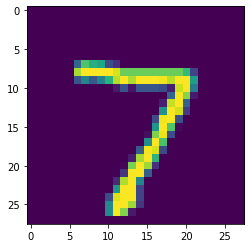

In [145]:
# Display the first image in test_dataset
import matplotlib.pyplot as plt
import numpy as np


def display_image(image):
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()


image = test_dataset[0][0]
print(type(image))
display_image(image)

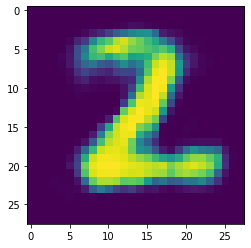

In [156]:
# View a pre-determined point in latent space
# Try changing x and y to look at different points in the latent space
x, y = 0.0, 0.0
result = model.decoder(torch.tensor([[x, y]]))
result = result.detach().view(1, 28, 28)
display_image(result)

Original


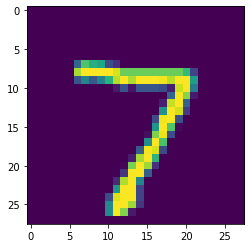

Encoding: tensor([[-19.9919,   3.1176]], grad_fn=<AddmmBackward0>)

Reconstructed


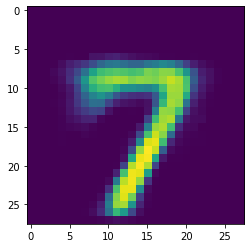

In [147]:
# Try changing index to different numbers
index = 0
image = test_dataset[index][0]
encoding, reconstruction = model(image.view(1, 784))
reconstruction = reconstruction.detach()
reconstruction = reconstruction.view(1, 28, 28)
print('Original')
display_image(image)
print(f'Encoding: {encoding}\n')
print('Reconstructed')
display_image(reconstruction)

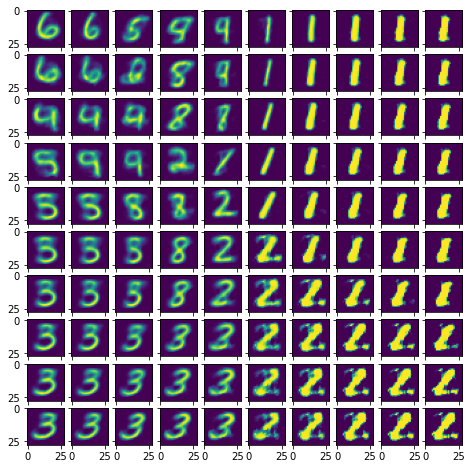

In [160]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

# Displays a 2d representation of the latent space
# The middle represents (0,0)
# This sets how many rows and columns the table has
step = 10
# This sets how far apart each sampling is from the next
size = 5
images = []
for i in range(step):
    for j in range(step):
        x = -size + i * (size*2)/(step-1)
        y = size - j * (size*2)/(step-1)
        result = model.decoder(torch.tensor([[x, y]]))
        result = result.detach().view(28,28)
        images.append(result)
        #print(x, y)

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(step, step),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()